## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [6]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

#Same as get_city_trajectories, but combines the data from all cities
def get_all_trajectories(split="train", normalized=False):
    total_inputs, total_outputs = get_city_trajectories(city=cities[0], split=split,normalized=normalized)
    
    for i in range(1,len(cities)):
        city = cities[i]
        inputs,outputs = get_city_trajectories(city=city, split=split,normalized=normalized)
        total_inputs = np.concatenate((total_inputs,inputs))
        
        if total_outputs is not None:
            total_outputs = np.concatenate((total_outputs,outputs))

    return total_inputs, total_outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
class ArgoverseDatasetAllCities(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, split:str, transform=None):
        super(ArgoverseDatasetAllCities, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_all_trajectories(split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
for city in cities:
    split = 'train'
    train_dataset  = ArgoverseDataset(city = city, split = split)
    print(len(train_dataset))
    
    
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)
print(len(train_dataset))

43041
55029
43544
24465
25744
11993
11993


## Create a DataLoader class for training

In [7]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

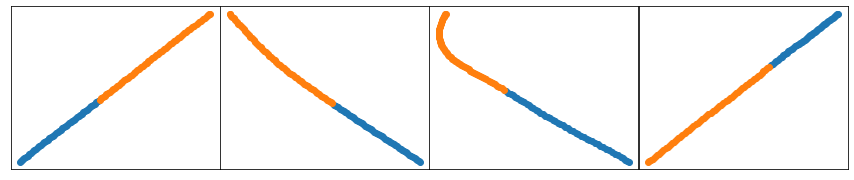

In [8]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

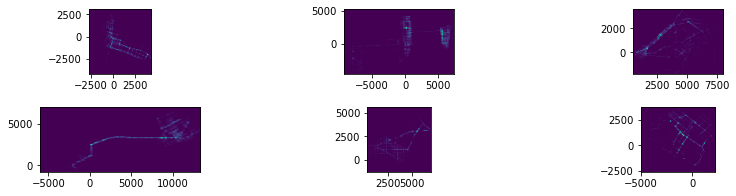

In [9]:
import numpy.random

def makeHeatmap(dataset, axis):
    train_loader = DataLoader(dataset,batch_size=len(dataset))
    #Heatmap of all input positions for all time steps specifically for a given dataset
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch

        x = []
        y = []
        for i in range(len(inp[0])):
            x = numpy.append(x,torch.squeeze(inp[:,i,0]).numpy())
            y = numpy.append(y,torch.squeeze(inp[:,i,1]).numpy())

        heatmap, xedges, yedges = np.histogram2d(x, y, bins=80)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        axis.imshow(heatmap.T, extent=extent, origin='lower')

split = 'train'
fig, axs = plt.subplots(2, 3, figsize=(15, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel() 
for i_city, city in enumerate(cities):
    train_dataset  = ArgoverseDataset(city = city, split = split)
    makeHeatmap(train_dataset, axs[i_city])
plt.show()

In [10]:
import torch.nn as nn

mlp = nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2)))

#From d2l's tutorial. Might be useful, but I'm ignoring it for now
#def init_weights(m):
#    if type(m) == nn.Linear:
#        nn.init.normal_(m.weight, std=0.01)


In [11]:
full_dataset  = ArgoverseDatasetAllCities(split = "train")
#Split into training and validation:
train_set, validation_set = torch.utils.data.random_split(full_dataset, [int(len(full_dataset)*5/6), len(full_dataset)-int(len(full_dataset)*5/6)])

#Batch size for both currently set to be the entire dataset. Might lead to problems with overfitting, but it doesn't learn anything when I don't do this
train_loader = DataLoader(train_set,batch_size=len(train_set),shuffle=True)
validation_loader = DataLoader(validation_set,batch_size=len(validation_set))

In [12]:
opt = torch.optim.Adam(mlp.parameters(),lr=0.004)

loss = nn.MSELoss()

num_epochs = 70

plot_every = 2
all_losses = []
all_losses2 = []#validation
total_loss = 0

for epoch in range(num_epochs):
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        inp = inp.float()
        out = out.float()
        l = ((mlp(inp) - out) ** 2).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        total_loss += l.item()
        #if i_batch % plot_every == 0 and i_batch != 0:
            #all_losses.append(total_loss / len(train_set))
    for i_batch, sample_batch in enumerate(validation_loader):
        inp, out = sample_batch
        inp = inp.float()
        out = out.float()
        l = ((mlp(inp) - out) ** 2).sum()
        print(f'(validation) epoch {epoch + 1}, loss {(l / len(validation_set)):f}')
        all_losses2.append(l.item() / len(validation_set))
    print(f'(train) epoch {epoch + 1}, loss {(total_loss / len(train_set)):f}')
    all_losses.append(total_loss / len(train_set))
    total_loss = 0
    

(validation) epoch 1, loss 1237646208.000000
(train) epoch 1, loss 1353862439.167340
(validation) epoch 2, loss 1092609664.000000
(train) epoch 2, loss 1259552607.677072
(validation) epoch 3, loss 918068224.000000
(train) epoch 3, loss 1111288211.243032
(validation) epoch 4, loss 783292480.000000
(train) epoch 4, loss 932851674.137937
(validation) epoch 5, loss 775774272.000000
(train) epoch 5, loss 795140330.889488
(validation) epoch 6, loss 707151296.000000
(train) epoch 6, loss 787622657.226900
(validation) epoch 7, loss 593884224.000000
(train) epoch 7, loss 717608604.410113
(validation) epoch 8, loss 532364896.000000
(train) epoch 8, loss 601913665.296987
(validation) epoch 9, loss 521315552.000000
(train) epoch 9, loss 539101094.602122
(validation) epoch 10, loss 518421664.000000
(train) epoch 10, loss 527886469.144237
(validation) epoch 11, loss 510230016.000000
(train) epoch 11, loss 525041387.341662
(validation) epoch 12, loss 501188288.000000
(train) epoch 12, loss 516807862.

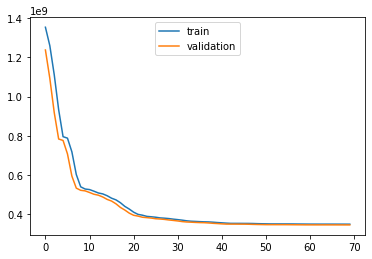

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses,label="train")

plt.plot(all_losses2,label="validation")
leg = plt.legend(loc='upper center')
plt.show()

In [17]:
#Not currently working well
def show_sample_batch2(sample_batch,prediction):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    print("visualizing")
    
    fig, axs = plt.subplots(1,batch_sz*2, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        if i == 0:
            print(inp[i,:,0])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        #axs[i].set_title("hello")
        
                
    for i in range(batch_sz):
        axs[i+batch_sz].xaxis.set_ticks([])
        axs[i+batch_sz].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        #if i == 0:
            #print(inp[i,:,0])
        axs[i+batch_sz].scatter(inp[i,:,0], inp[i,:,1])
        print(prediction[i,:,0])
        print(inp[i,:,0])
        #axs[i+batch_sz].scatter(prediction[i,:,0], prediction[i,:,1])


In [18]:
#Validation

validation_loader2 = DataLoader(validation_set,batch_size=2)

for i_batch, sample_batch in enumerate(validation_loader2):
    inp, out = sample_batch
    inp = inp.float()
    out = out.float()
    print(inp.shape)
    #print(out)
    #print(mlp(inp))
    l = loss(mlp(inp) ,out)
    print(l)
    #show_sample_batch2(sample_batch,mlp(inp).detach())
    if i_batch > 5:
        break

torch.Size([2, 50, 2])
tensor(2009445.7500, grad_fn=<MseLossBackward>)
torch.Size([2, 50, 2])
tensor(2407367.5000, grad_fn=<MseLossBackward>)
torch.Size([2, 50, 2])
tensor(1773528.2500, grad_fn=<MseLossBackward>)
torch.Size([2, 50, 2])
tensor(4240038.5000, grad_fn=<MseLossBackward>)
torch.Size([2, 50, 2])
tensor(3349084.7500, grad_fn=<MseLossBackward>)
torch.Size([2, 50, 2])
tensor(137518.8125, grad_fn=<MseLossBackward>)
torch.Size([2, 50, 2])
tensor(548791.5000, grad_fn=<MseLossBackward>)


In [19]:
test_lengths = []
for city in cities:
    split = 'test'
    test_dataset  = ArgoverseDataset(city = city, split = split)
    test_lengths.append(len(test_dataset))
    
for le in test_lengths:
    print(le)

6325
7971
6361
3671
3829
1686


In [292]:
#Test

split = 'test'
counter = 0
currCity = 0
test_input, test_output = get_all_trajectories(split="test", normalized=False)
#We can't use a dataset or a dataloader because they don't work for the test set (something to do with the fact that the test set doesn't have outputs)

with open('predictions.txt', 'w') as f:
    print("hello",file=f, flush=True)
    for i_batch, curr_input in enumerate(test_input):
        #curr_input is a numpy array, so first we need to turn it into a tensor, then add an extra dimension around it, then make it a float tensor instead of a double tensor
        predict = mlp(torch.from_numpy(curr_input).unsqueeze(0).float())

        print("" + str(counter) + "_" + str(cities[currCity]),end='',file=f)
        for coor in predict[0]:
            print("," + str(coor[0].item()) + "," + str(coor[1].item()),end='',file=f)
        print(file=f, flush=True)
        counter = counter+1
        if counter >= test_lengths[currCity]:
            counter = 0
            currCity = currCity+1

    f.close()

Inputs (6325, 50, 2) (7971, 50, 2)
Inputs (14296, 50, 2) (6361, 50, 2)
Inputs (20657, 50, 2) (3671, 50, 2)
Inputs (24328, 50, 2) (3829, 50, 2)
Inputs (28157, 50, 2) (1686, 50, 2)
